In [1]:
import sys
sys.path.append("./../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

from fbprophet import Prophet

sns.set()

In [2]:
from datetime import datetime 

today = datetime.strftime(datetime.today(),"%Y-%m-%d")
import yfinance as yf
# Request historical data for past 5 years
df = yf.download("^GSPC", start='2019-01-01', end=today)
df.columns = [i.replace(" ", "_") for i in list(df)]
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2018-12-31,2498.939941,2509.239990,2482.820068,2506.850098,2506.850098,3442870000
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3822860000
2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4213410000
2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,2549.689941,4104710000


In [3]:
train_df = df.loc[:"2021-07-31"]
test_df = df.loc["2021-08-01":]

In [4]:
prices_df = pd.DataFrame(columns = ["ds", "y"])
prices_df["ds"] = df.index
prices_df["y"] = df["Adj_Close"].values

prices_train_df = pd.DataFrame(columns = ["ds", "y"])
prices_train_df["ds"] = train_df.index
prices_train_df["y"] = train_df["Adj_Close"].values

prices_test_df = pd.DataFrame(columns = ["ds", "y"])
prices_test_df["ds"] = test_df.index
prices_test_df["y"] = test_df["Adj_Close"].values

In [5]:
prices_train_df.head()

,ds,y
0,2018-12-31,2506.850098
1,2019-01-02,2510.030029
2,2019-01-03,2447.889893
3,2019-01-04,2531.939941
4,2019-01-07,2549.689941


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.52004
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2009.25    0.00329569       311.858       4.873      0.4873      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2039.23    0.00997755        112.27           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2048.75      0.010459       131.688           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2059.67    0.00163186       88.6973      0.3199      0.9967      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2062.87    0.00118136       107.843           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

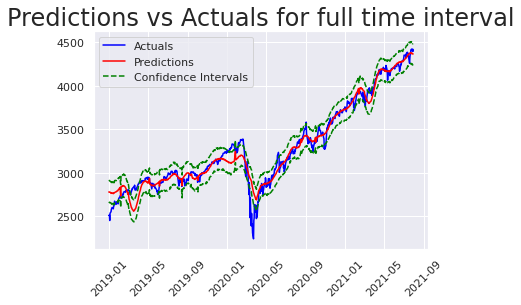

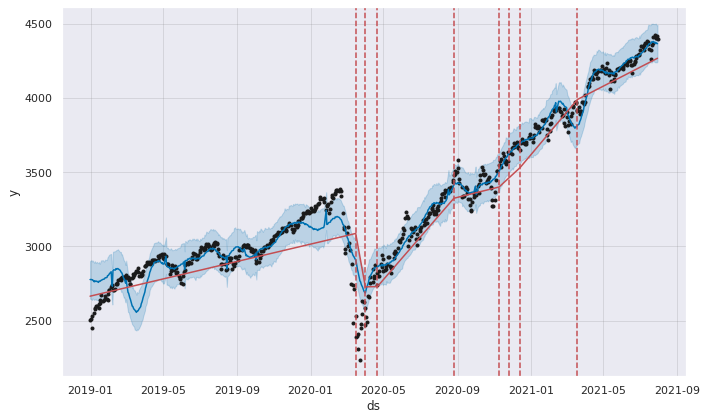

In [6]:
from src.algorithms.prophet.prophet import Prophet_MODEL
changepoints = ['2020-03-16', '2020-04-01', '2020-04-21', '2020-07-21', '2020-08-06', '2020-08-26', '2020-09-11', '2020-11-09', '2020-11-26', '2020-12-14', '2021-03-19', '2021-04-06']
changepoints.extend(["2021-07-12"])
prophet_model = Prophet_MODEL(
    prophet_kwargs=dict(growth="linear",changepoints=changepoints,changepoint_prior_scale=0.18),
    country="KR")
prophet_model.fit(prices_train_df)
time_list , y_list = prophet_model.train["ds"].values ,  prophet_model.train["y"].values
prophet_model.plot_time_interval(time_list ,y_list)
a = prophet_model.plot_changepoints(time_list)

In [8]:
change_points = [str(i.get_xdata()[0]) for i in a[1:]]
print(change_points)

['2020-03-16 00:00:00', '2020-04-01 00:00:00', '2020-04-21 00:00:00', '2020-08-26 00:00:00', '2020-11-09 00:00:00', '2020-11-26 00:00:00', '2020-12-14 00:00:00', '2021-03-19 00:00:00']


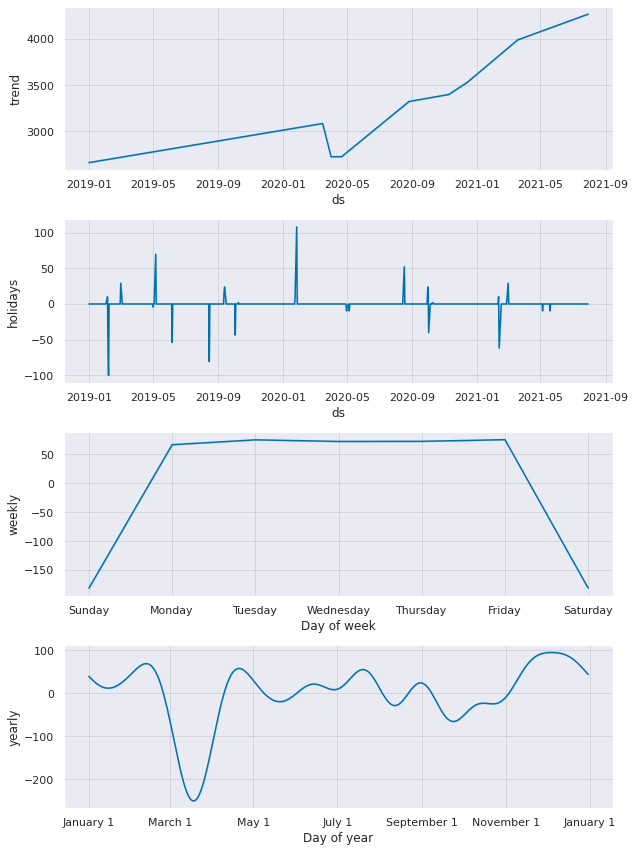

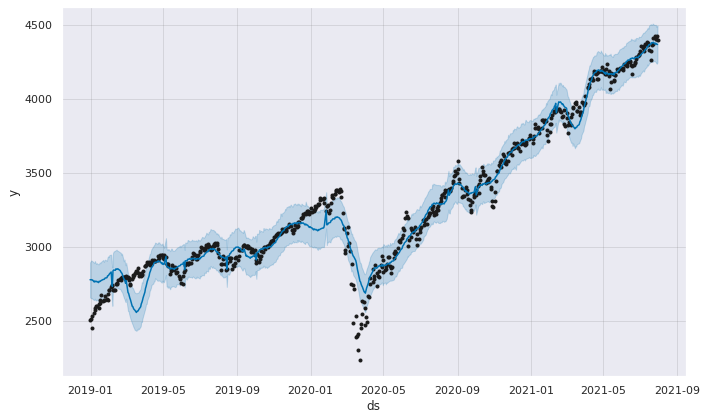

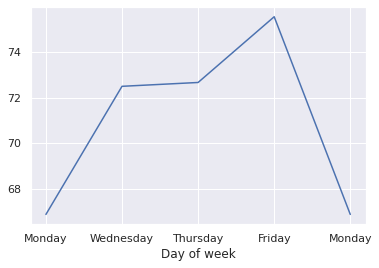

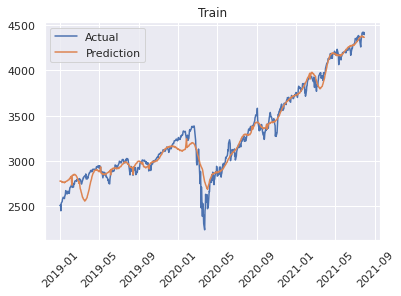

,mae,mse,msle,r2,mede,mape
train,65.446583,9682.628355,0.001192,0.961644,40.990112,0.0217


In [9]:
tr_pred_result = prophet_model.predict_train()
prophet_model.plot_component(tr_pred_result)
prophet_model.plot_prediction(tr_pred_result)
prophet_model.plot_weekly(tr_pred_result)
prophet_model.plot_trend(prophet_model.train , target_name="y",title="Train")
prophet_model.metrics(target_name="y")

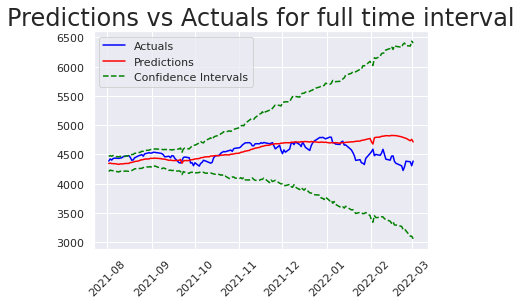

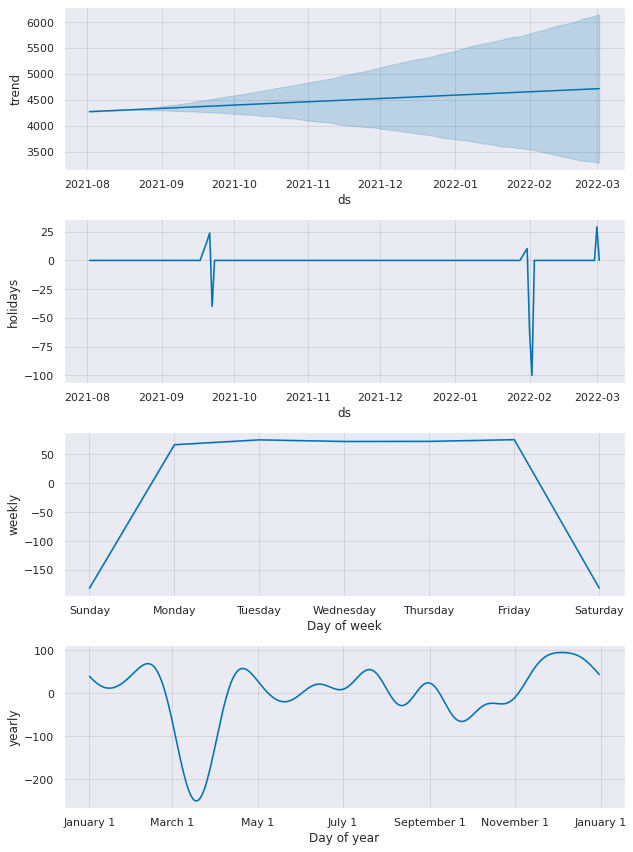

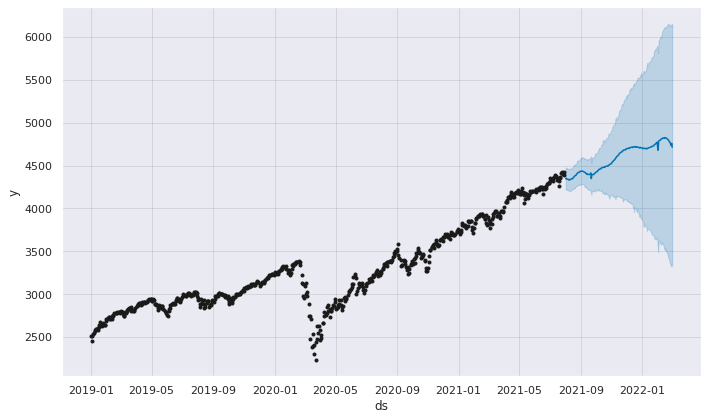

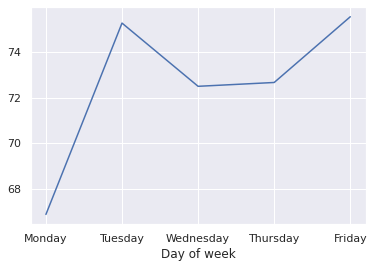

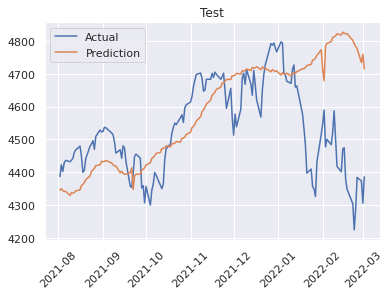

,mae,mse,msle,r2,mede,mape
train,65.446583,9682.628355,0.001192,0.961644,40.990112,0.021700
test,126.598964,31445.713455,0.001506,-0.758500,87.436249,0.028382


In [10]:
time_list , y_list = prices_test_df["ds"].values , prices_test_df["y"].values
prophet_model.plot_time_interval(time_list ,y_list)
test_pred_result = prophet_model.predict(prices_test_df["ds"].values)
prophet_model.plot_component(test_pred_result)
prophet_model.plot_prediction(test_pred_result)
prophet_model.plot_weekly(test_pred_result)
prophet_model.plot_trend(prices_test_df , target_name="y",title="Test")
prophet_model.metrics(target_name="y",test=prices_test_df)

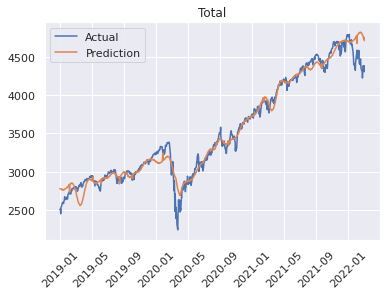

In [11]:
prophet_model.plot_trend(pd.concat([prices_train_df , prices_test_df],axis=0) , target_name="y",title="Total")